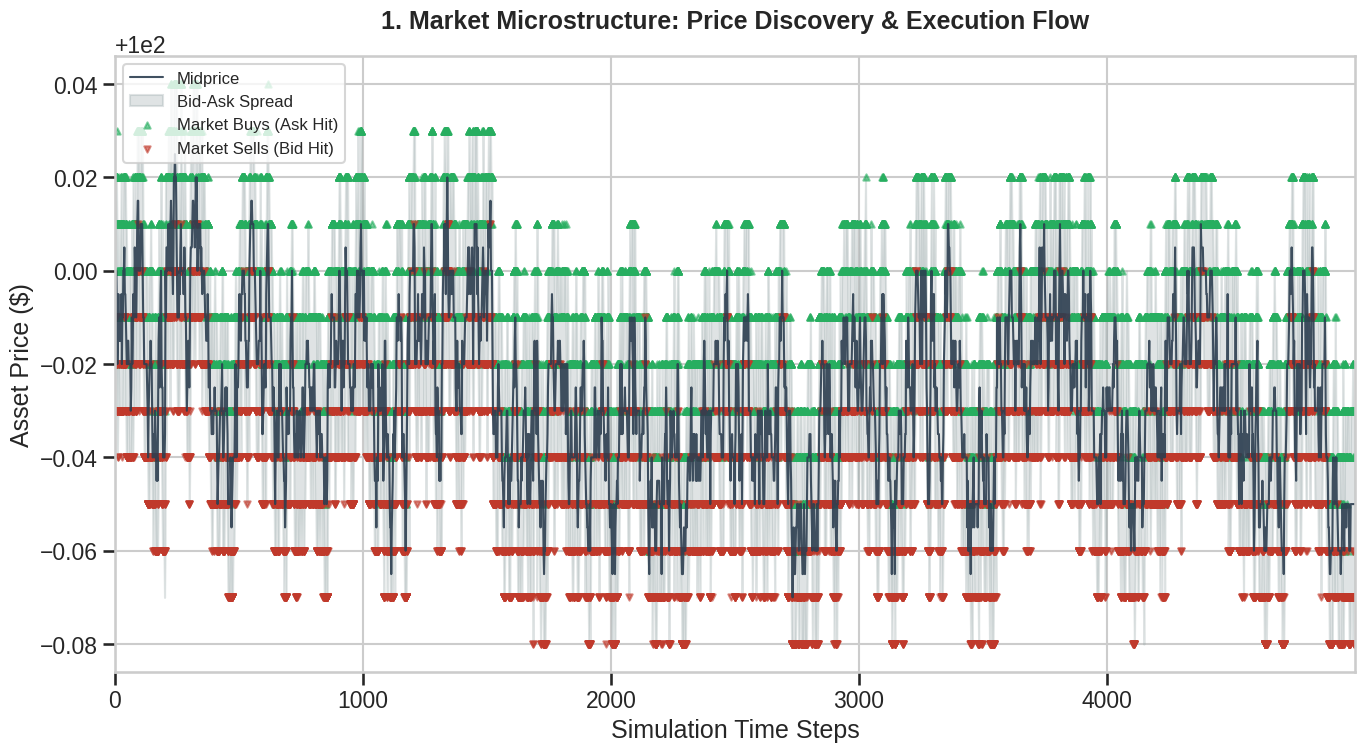

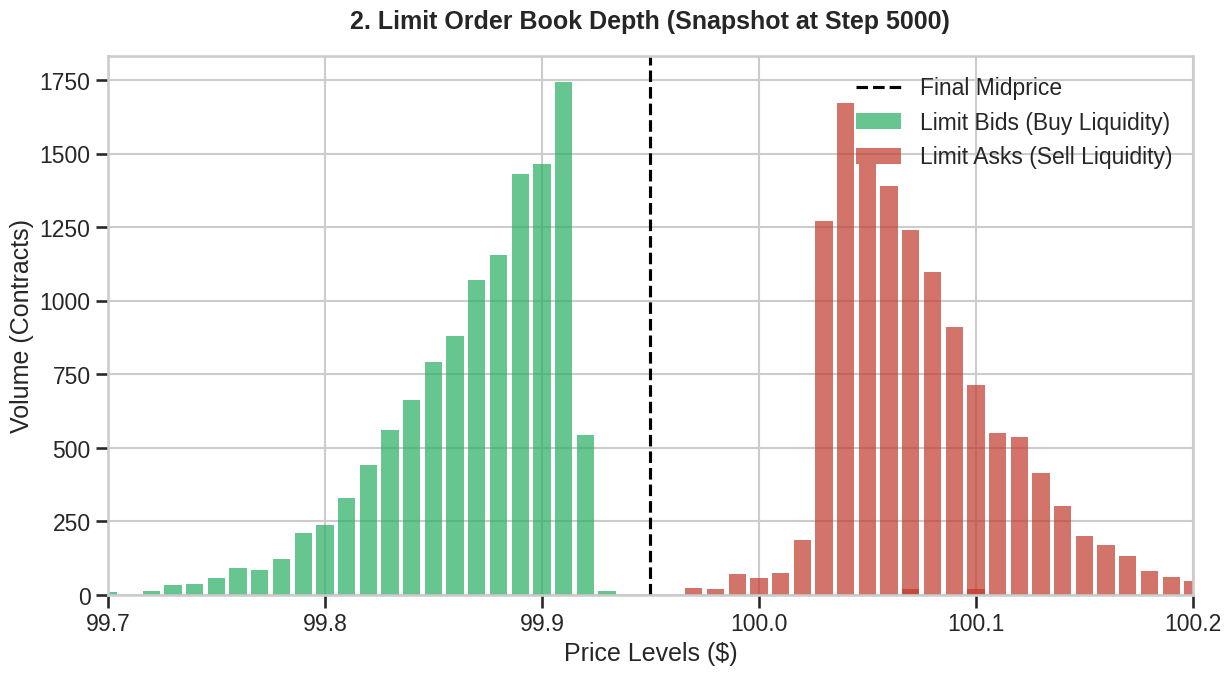

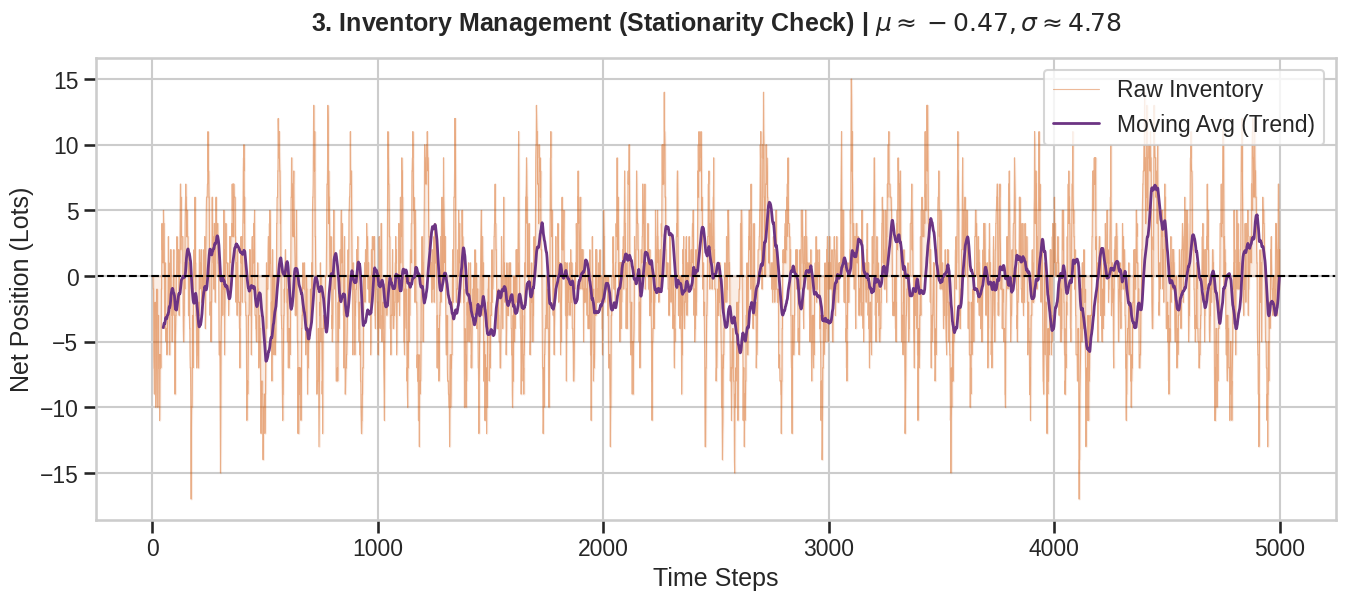

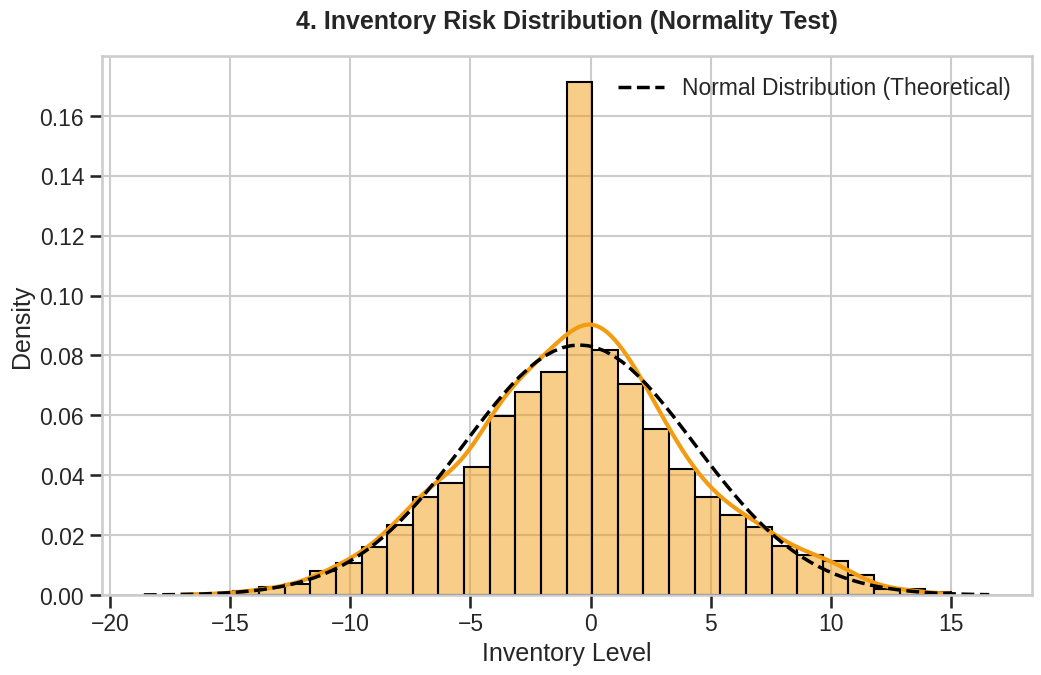

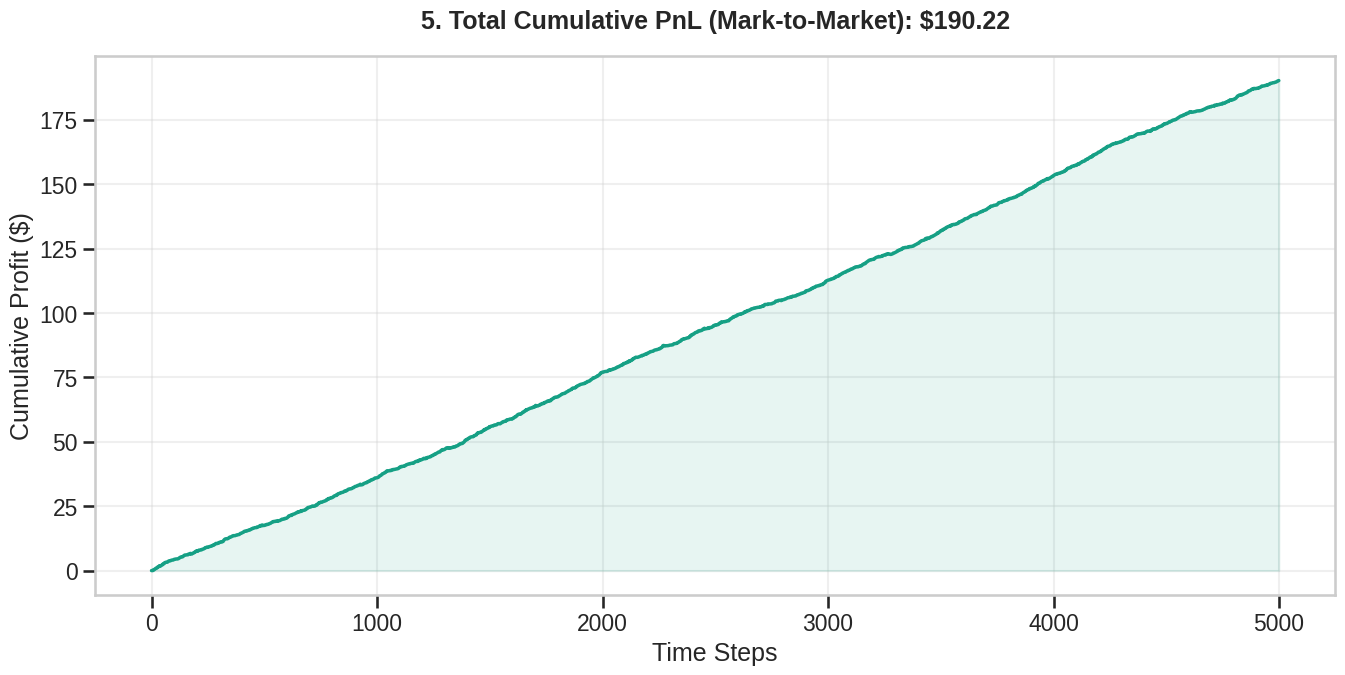

In [1]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from enum import Enum, auto
from collections import deque
from typing import Dict, List, Optional, Set
from scipy import stats


##### CONFIGURATION & TYPES
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Visual Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

class Side(Enum):

    BUY = auto()
    SELL = auto()

class OrdType(Enum):

    LIMIT = auto()
    MARKET = auto()

@dataclass
class Trade:

    ts: float
    price: float
    qty: int
    aggressor_side: Side
    resting_oid: int

@dataclass
class Order:

    oid: int
    side: Side
    qty: int
    price: float
    ts: float


##### CORE ENGINE: LIMIT ORDER BOOK
class OrderBook:
    """
    High-performance Limit Order Book.
    Uses HashMaps for O(1) lookups and Bisect for O(log N) insertions.
    """
    def __init__(self, tick_size=0.01):
        self.tick_size = tick_size

        # Data Structures for Bids and Asks
        self.bids: Dict[float, Deque[Order]] = {}
        self.asks: Dict[float, Deque[Order]] = {}

        # Sorted price lists for fast Best Bid/Offer lookup
        self.bid_prices: List[float] = []  # Descending
        self.ask_prices: List[float] = []  # Ascending

        # OID registry for O(1) cancellation
        self.oid_map: Dict[int, Order] = {}

        self.last_oid = 0
        self.trades: List[Trade] = []

    def get_midprice(self) -> float:
        """Returns the current midprice (Fair Value)."""
        if not self.bid_prices or not self.ask_prices:
            return None
        return (self.bid_prices[0] + self.ask_prices[0]) / 2.0

    def get_best_bid(self): return self.bid_prices[0] if self.bid_prices else None
    def get_best_ask(self): return self.ask_prices[0] if self.ask_prices else None

    def submit_limit(self, side: Side, qty: int, price: float, ts: float) -> int:
        """
        Submits a Limit Order.
        Complexity: O(log N) due to binary search insertion of price level.
        """
        self.last_oid += 1
        oid = self.last_oid
        order = Order(oid, side, qty, price, ts)

        # Select appropriate side
        price_levels = self.bids if side == Side.BUY else self.asks
        price_list = self.bid_prices if side == Side.BUY else self.ask_prices

        # If price level doesn't exist, insert it keeping order
        if price not in price_levels:
            price_levels[price] = deque()
            import bisect
            if side == Side.BUY:
                bisect.insort(price_list, price, key=lambda x: -x) # Descending for Bids
            else:
                bisect.insort(price_list, price) # Ascending for Asks

        # Add order to level (Time Priority)
        price_levels[price].append(order)
        self.oid_map[oid] = order
        return oid

    def match_market_order(self, side: Side, qty: int, ts: float) -> List[Trade]:
        """
        Executes a Market Order against resting liquidity.
        """
        trades_generated = []
        # Aggressor BUY hits Asks, Aggressor SELL hits Bids
        opponent_prices = self.ask_prices if side == Side.BUY else self.bid_prices
        opponent_levels = self.asks if side == Side.BUY else self.bids

        remaining_qty = qty

        # Walk the book
        while remaining_qty > 0 and opponent_prices:
            best_price = opponent_prices[0]
            level_queue = opponent_levels[best_price]

            while level_queue and remaining_qty > 0:
                maker_order = level_queue[0]
                exec_qty = min(remaining_qty, maker_order.qty)

                # Execute Trade
                trade = Trade(ts, maker_order.price, exec_qty, side, maker_order.oid)
                self.trades.append(trade)
                trades_generated.append(trade)

                remaining_qty -= exec_qty
                maker_order.qty -= exec_qty

                # Clean up filled orders
                if maker_order.qty == 0:
                    level_queue.popleft()
                    del self.oid_map[maker_order.oid]

            # Clean up empty price levels
            if not level_queue:
                del opponent_levels[best_price]
                opponent_prices.pop(0)

        return trades_generated

    def cancel_order(self, oid: int):
        """Cancels an existing order in O(1)."""
        if oid not in self.oid_map: return
        order = self.oid_map[oid]

        levels = self.bids if order.side == Side.BUY else self.asks
        prices = self.bid_prices if order.side == Side.BUY else self.ask_prices

        queue = levels.get(order.price)
        if queue:
            try:
                queue.remove(order)
                if not queue:
                    del levels[order.price]
                    prices.remove(order.price)
            except ValueError: pass
        del self.oid_map[oid]


##### STRATEGY AGENT: MARKET MAKER
class MarketMaker:

    def __init__(self, book: OrderBook, initial_cash=0):
        self.book = book
        self.cash = initial_cash
        self.inventory = 0
        self.active_orders: Set[int] = set()

        # STRATEGY PARAMETERS
        self.risk_aversion = 0.05    # Gamma: Controls skew intensity
        self.qty_per_quote = 10      # Standard quote size
        self.window_tick = 4         # Target spread width
        self.max_inventory = 100     # Hard risk limit

        # METRICS TRACKING
        self.history_ts = []
        self.history_pnl = []
        self.history_inv = []

    def get_valuation(self, mid_price):
        """Calculates Mark-to-Market (MtM) value of the portfolio."""
        return self.cash + (self.inventory * mid_price)

    def quote(self, ts: float):
        """Updates quotes based on current inventory (Skewing)."""
        # Cancel previous quotes
        for oid in list(self.active_orders):
            self.book.cancel_order(oid)
        self.active_orders.clear()

        mid = self.book.get_midprice()
        if not mid: return

        # Calculate Reservation Price
        # r = s - q * gamma * sigma^2 (Linear approximation)
        skew = self.inventory * self.risk_aversion * self.book.tick_size
        reservation_price = mid - skew

        # Determine Bid/Ask around Reservation Price
        half_spread = (self.window_tick * self.book.tick_size) / 2

        bid_px = round((reservation_price - half_spread) / self.book.tick_size) * self.book.tick_size
        ask_px = round((reservation_price + half_spread) / self.book.tick_size) * self.book.tick_size

        # Safety check: prevent crossed quotes
        if ask_px <= bid_px:
            ask_px = bid_px + self.book.tick_size

        # Submit new quotes if within risk limits
        if self.inventory < self.max_inventory:
            oid_bid = self.book.submit_limit(Side.BUY, self.qty_per_quote, bid_px, ts)
            self.active_orders.add(oid_bid)

        if self.inventory > -self.max_inventory:
            oid_ask = self.book.submit_limit(Side.SELL, self.qty_per_quote, ask_px, ts)
            self.active_orders.add(oid_ask)

    def on_trade_fill(self, trade: Trade):
        """Callback when one of MM's orders is executed."""
        if trade.resting_oid in self.active_orders:
            if trade.aggressor_side == Side.BUY:
                # MM sold (Ask hit)
                self.inventory -= trade.qty
                self.cash += trade.qty * trade.price
            else:
                # MM bought (Bid hit)
                self.inventory += trade.qty
                self.cash -= trade.qty * trade.price

            self.active_orders.remove(trade.resting_oid)

    def record_metrics(self, ts):
        """Snapshots current PnL and Inventory."""
        mid = self.book.get_midprice()
        if mid:
            total_pnl = self.get_valuation(mid)
            self.history_ts.append(ts)
            self.history_pnl.append(total_pnl)
            self.history_inv.append(self.inventory)


##### SIMULATION RUNNER
def run_simulation_and_return():

    book = OrderBook(tick_size=0.01)
    mm = MarketMaker(book)

    # Seed initial liquidity to prevent empty book
    start_price = 100.00
    for i in range(1, 15):
        book.submit_limit(Side.BUY, 20, start_price - i*0.01, 0)
        book.submit_limit(Side.SELL, 20, start_price + i*0.01, 0)

    # Simulation Parameters
    STEPS = 5000
    noise_lambda = 8       # Orders per step (Poisson)
    true_price = 100.00
    volatility = 0.02

    market_history = []

    for t in range(STEPS):
        ts = float(t)
        # Random Walk for True Price
        true_price += np.random.normal(0, volatility)

        # 1. MM Updates Quotes
        mm.quote(ts)

        # 2. Noise Traders Arrival
        num_noise_orders = np.random.poisson(noise_lambda)
        current_mid = book.get_midprice() or true_price
        trades_in_step = []

        for _ in range(num_noise_orders):
            is_buy = random.random() > 0.5
            side = Side.BUY if is_buy else Side.SELL

            if random.random() < 0.60:
                # Market Orders
                qty = random.randint(1, 5)
                fills = book.match_market_order(side, qty, ts)
                trades_in_step.extend(fills)
            else:
                # Limit Orders
                qty = random.randint(1, 5)
                offset = abs(np.random.normal(0, 0.08))
                px = current_mid - offset if is_buy else current_mid + offset
                px = round(px / 0.01) * 0.01
                book.submit_limit(side, qty, px, ts)

        # Notify MM of fills
        for trade in trades_in_step:
            mm.on_trade_fill(trade)

        # Record Data
        mm.record_metrics(ts)

        # Snapshot LOB state
        bb = book.get_best_bid()
        ba = book.get_best_ask()
        if bb and ba:
            market_history.append({'ts': ts, 'bid': bb, 'ask': ba, 'mid': (bb+ba)/2})

    return mm, book, pd.DataFrame(market_history)


##### VISUALIZATION SYSTEM

def plot_separate_charts(mm, book, df_market):

    df_mm = pd.DataFrame({
        'ts': mm.history_ts,
        'pnl': mm.history_pnl,
        'inventory': mm.history_inv,
    })

    total_steps = len(df_market)

    # CHART 1: Market Dynamics
    plt.figure(figsize=(16, 8))
    df_plot = df_market.iloc[::2] if len(df_market) > 2000 else df_market
    plt.plot(df_plot['ts'], df_plot['mid'], color='#2c3e50', lw=1.5, alpha=0.9, label='Midprice')
    plt.fill_between(df_plot['ts'], df_plot['bid'], df_plot['ask'],
                     color='#95a5a6', alpha=0.3, label='Bid-Ask Spread')

    trades_data = [{'ts': t.ts, 'price': t.price, 'side': t.aggressor_side} for t in book.trades]
    if trades_data:
        df_trades = pd.DataFrame(trades_data)
        buys = df_trades[df_trades['side'] == Side.BUY]
        sells = df_trades[df_trades['side'] == Side.SELL]
        plt.scatter(buys['ts'], buys['price'], c='#27ae60', s=20, alpha=0.6, marker='^', label='Market Buys (Ask Hit)')
        plt.scatter(sells['ts'], sells['price'], c='#c0392b', s=20, alpha=0.6, marker='v', label='Market Sells (Bid Hit)')

    plt.title("1. Market Microstructure: Price Discovery & Execution Flow", fontsize=18, fontweight='bold', pad=20)
    plt.ylabel("Asset Price ($)")
    plt.xlabel("Simulation Time Steps")
    plt.legend(loc='upper left', frameon=True, fontsize=12)
    plt.margins(x=0)
    plt.show()

    # CHART 2: Depth of Book
    plt.figure(figsize=(14, 7))
    bids_vol = {}
    asks_vol = {}
    for price, orders in book.bids.items():
        vol = sum(o.qty for o in orders)
        if vol > 0: bids_vol[price] = vol
    for price, orders in book.asks.items():
        vol = sum(o.qty for o in orders)
        if vol > 0: asks_vol[price] = vol

    final_mid = df_market['mid'].iloc[-1]
    plt.bar(bids_vol.keys(), bids_vol.values(), color='#27ae60', alpha=0.7, width=0.008, label='Limit Bids (Buy Liquidity)')
    plt.bar(asks_vol.keys(), asks_vol.values(), color='#c0392b', alpha=0.7, width=0.008, label='Limit Asks (Sell Liquidity)')
    plt.axvline(final_mid, color='black', linestyle='--', label='Final Midprice')

    plt.title(f"2. Limit Order Book Depth (Snapshot at Step {total_steps})", fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Price Levels ($)")
    plt.ylabel("Volume (Contracts)")
    plt.xlim(final_mid - 0.25, final_mid + 0.25)
    plt.legend(loc='upper right')
    plt.show()

    # CHART 3: Inventory Management
    plt.figure(figsize=(16, 6))


    plt.plot(df_mm['ts'], df_mm['inventory'], color='#d35400', lw=0.8, alpha=0.4, label='Raw Inventory')


    rolling_mean = df_mm['inventory'].rolling(window=50).mean()
    plt.plot(df_mm['ts'], rolling_mean, color='#6c3483', lw=2, label='Moving Avg (Trend)')


    plt.fill_between(df_mm['ts'], df_mm['inventory'], 0, color='#d35400', alpha=0.1)
    plt.axhline(0, color='black', lw=1.5, ls='--')

    mu = df_mm['inventory'].mean()
    sigma = df_mm['inventory'].std()

    plt.title(rf"3. Inventory Management (Stationarity Check) | $\mu \approx {mu:.2f}, \sigma \approx {sigma:.2f}$",
              fontsize=18, fontweight='bold', pad=20)
    plt.ylabel("Net Position (Lots)")
    plt.xlabel("Time Steps")
    plt.legend(loc='upper right', frameon=True)
    plt.show()

    # CHART 4: Statistical Distribution
    plt.figure(figsize=(12, 7))
    sns.histplot(data=df_mm, x='inventory', kde=True, stat="density",
                 color='#f39c12', bins=30, line_kws={'lw': 3})

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, p, 'k', linewidth=2.5, linestyle='--', label='Normal Distribution (Theoretical)')

    plt.title("4. Inventory Risk Distribution (Normality Test)", fontsize=18, fontweight='bold', pad=20)
    plt.xlabel("Inventory Level")
    plt.legend()
    plt.show()

    #  CHART 5: PnL
    plt.figure(figsize=(16, 7))
    plt.plot(df_mm['ts'], df_mm['pnl'], color='#16a085', lw=2.5)
    plt.fill_between(df_mm['ts'], df_mm['pnl'], 0, color='#16a085', alpha=0.1)

    final_pnl = df_mm['pnl'].iloc[-1]
    plt.title(f"5. Total Cumulative PnL (Mark-to-Market): ${final_pnl:.2f}", fontsize=18, fontweight='bold', pad=20)
    plt.ylabel("Cumulative Profit ($)")
    plt.xlabel("Time Steps")
    plt.grid(True, alpha=0.3)
    plt.show()


##### MAIN EXECUTION

if __name__ == "__main__":
    # Run the simulation
    mm_sim, book_sim, market_data = run_simulation_and_return()

    # Generate charts
    plot_separate_charts(mm_sim, book_sim, market_data)